In [211]:
# import Libraries
import tweepy
import pandas as pd
import numpy as np
import string
import re

import preprocessor as p
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from textblob import TextBlob

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\waleed
[nltk_data]     traders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [212]:
# twitter App access keys for @user
 
# Consumer
CONSUMER_KEY    = '1A1p7FrKfEYoVpjG4jSKloEB6'
CONSUMER_SECRET = 'Z4lxkyok4riQrqNQoyGznhPTjksSk4P9yfIctn4NagpSlHVQlf'
 
# Access:
ACCESS_TOKEN  = '886272234-P4ECVJQwZTzBxIsrSH6yR8xuOTGjv5Me5sQZiK3A'
ACCESS_SECRET = '8OhCtzsKI9cGx6ICMwdoCl4hWfHm3ejiuwxTjZEBOSBjC'

In [128]:
# We import our access keys:
 
def app_auth():
    
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    api = tweepy.API(auth)
    return api

In [129]:
tweet_extract = app_auth()

# input for term to be searched and how many tweets to search
search_term = input("Enter keyword or tag to search: ")
no_of_terms = int(input("Enter no: of tweets to search: "))

tweets = tweet_extract.user_timeline(screen_name = search_term, count = no_of_terms)

print("number of tweets extracted: {}.\n".format(len(tweets)))
 
print("10 latest tweets are :\n")
for tweet in tweets[:10]:
    print(tweet.text)
    print('\n')

Enter keyword or tag to search: WHO
Enter no: of tweets to search: 200
number of tweets extracted: 200.

10 latest tweets are :

WHO leads global advocacy to test all suspected #COVID19 cases to stop transmission.

Healthcare workers in #DRC 🇨🇩… https://t.co/K1jrYNyZVH


RT @WHO_Europe: 🔵 Let’s get moving! Follow @WHO as this year’s #HealthForAll challenge goes global and virtual.

Wherever you are join us a…


RT @WHOSEARO: The virtual Walk the Talk for #HealthForAll by WHO South-East Asia is now live! 

You can tune in here:
🎞️ https://t.co/Z3YL4…


RT @WHOSEARO: It's happening today!

Don't miss tuning into the virtual Walk the Talk for #HealthForAll by WHO South-East Asia Region.

Joi…


WHO is committed to supporting countries’ health systems to respond to all health emergencies, including #COVID19.… https://t.co/1GzoVVFYgJ


Don't miss tuning into the first virtual Walk The Talk for #HealthForAll!

11:00 am CEST, here @WHO. 

Join us for… https://t.co/b8ZM9MNZ77


RT @DrTedros: T

In [130]:
# Creating a DataFrame of fetch tweets
df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
df['ID'] = np.array([tweet.id for tweet in tweets])
df['Date'] = np.array([tweet.created_at for tweet in tweets])
df['Source'] = np.array([tweet.source for tweet in tweets])
df['Likes'] = np.array([tweet.favorite_count for tweet in tweets])
df['Retweets'] = np.array([tweet.retweet_count for tweet in tweets])
display(df.head(10))

,Tweets,ID,Date,Source,Likes,Retweets
0,WHO leads global advocacy to test all suspecte...,1261931572263038976,2020-05-17 08:08:27,Twitter for iPhone,0,2
1,RT @WHO_Europe: 🔵 Let’s get moving! Follow @WH...,1261930274817966082,2020-05-17 08:03:17,Twitter for iPhone,0,8
2,RT @WHOSEARO: The virtual Walk the Talk for #H...,1261892348063223809,2020-05-17 05:32:35,Twitter Web App,0,34
3,RT @WHOSEARO: It's happening today!\n\nDon't m...,1261889521609773057,2020-05-17 05:21:21,Twitter for iPhone,0,34
4,WHO is committed to supporting countries’ heal...,1261874234210627584,2020-05-17 04:20:36,Twitter for iPhone,199,39
5,Don't miss tuning into the first virtual Walk ...,1261776803334668291,2020-05-16 21:53:27,Twitter Web App,447,150
6,RT @DrTedros: Thank you to @WHO_Europe and all...,1261776114009202688,2020-05-16 21:50:42,Twitter Web App,0,49
7,RT @DrTedros: Huge thanks to @WHOAFRO &amp; al...,1261776106039971842,2020-05-16 21:50:41,Twitter Web App,0,49
8,RT @DrTedros: Thank you @WHOWPRO for kicking o...,1261776095654879233,2020-05-16 21:50:38,Twitter Web App,0,64
9,"RT @pahowho: 👋 Remember, this Saturday and Sun...",1261771960129925122,2020-05-16 21:34:12,Twitter Web App,0,38


Creation of content sources:
* Twitter for iPhone
* Twitter Web App
* Periscope
* Socialbakers


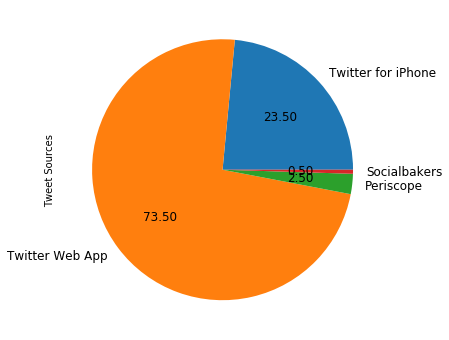

In [207]:
sources = []
for source in df['Source']:
    if source not in sources:
        sources.append(source)
        
        
# We print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

# We create a numpy vector mapped to labels:
percent = np.zeros(len(sources))
 
for source in df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100
    
# Pie chart:
pie_chart = pd.Series(percent, index=sources, name='Tweet Sources')
pie_chart.plot.pie(fontsize=12, autopct='%.2f', figsize=(6, 6));

In [131]:
tweets_liked = pd.Series(data = df['Likes'].values)   
tweets_retweeted = pd.Series(data = df['Retweets'].values) 

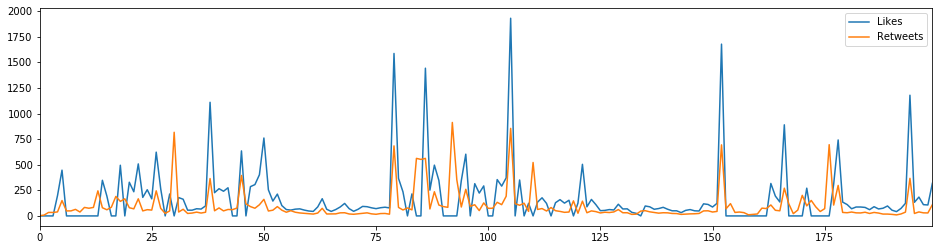

In [132]:
# Likes vs retweets visualization:
tweets_liked.plot(figsize=(16,4), label="Likes", legend=True)
tweets_retweeted.plot(figsize=(16,4), label="Retweets", legend=True)

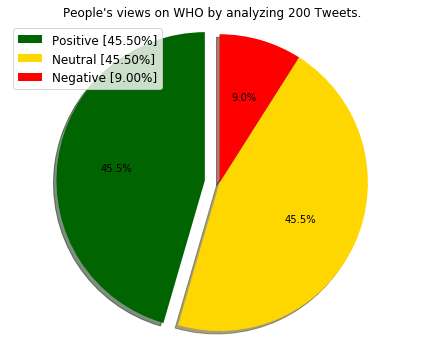

In [199]:

# creating some variables to store info

polarity = 0
positive = 0
negative = 0
neutral = 0
        
positive_word = []
negtive_word = []

#tweets = []
tweet_text = []


def clean_tweet(tweet):
    
    # Remove Links, Special Characters etc from tweet
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", tweet).split())


# function to calculate percentage
def calculate_percentage(part, whole):
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')

def plot_chart(positive, neutral, negative, search_term, no_of_terms):
    
    labels = ['Positive [' + str(positive) + '%]', 'Neutral [' + str(neutral) + '%]','Negative [' + str(negative) + '%]']
    sizes = [positive, neutral, negative]
    colors = ['darkgreen', 'gold', 'red']
    explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots(figsize=(6, 5))
    ax1.pie(sizes,colors= colors, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
    plt.legend(labels, loc="upper left" , prop={'size': 12})
    plt.title('People\'s views on ' + search_term + ' by analyzing ' + str(no_of_terms) + ' Tweets.')
    ax1.axis('equal')
    plt.tight_layout()
    plt.show()
    
# iterating through tweets fetched
for tweet in tweets:
    
    #Append to temp so that we can store in csv later. I use encode UTF-8
    tweet_text.append(clean_tweet(tweet.text).encode('utf-8'))
    # print (tweet.text.translate(non_bmp_map))    #print tweet's text
    analysis = TextBlob(tweet.text)
    # print(analysis.sentiment)  # print tweet's polarity
    polarity += analysis.sentiment.polarity
    
    # adding reaction of how people are reacting to find average later
    if (analysis.sentiment.polarity == 0): 
        neutral += 1
    elif (analysis.sentiment.polarity > 0 ):
        positive_word.append(tweet.text)
        positive += 1
    elif (analysis.sentiment.polarity < 0):
        negtive_word.append(tweet.text)
        negative += 1
              

            
# finding average of how people are reacting
positive = calculate_percentage(positive, no_of_terms)
negative = calculate_percentage(negative, no_of_terms)
neutral = calculate_percentage(neutral, no_of_terms)

plot_chart(positive, neutral, negative, search_term, no_of_terms)

In [134]:
def extract_hashtags(tweets):
    hashtags = []
    # Loop over the words in the tweet
    for tweet in tweets:
        hashtag = re.findall(r"#(\w+)", tweet.text)
        hashtags.append(hashtag)

    return hashtags

# extracting hashtags from non racist/sexist tweets
hashtag = extract_hashtags(tweets)
hashtag = sum(hashtag,[])

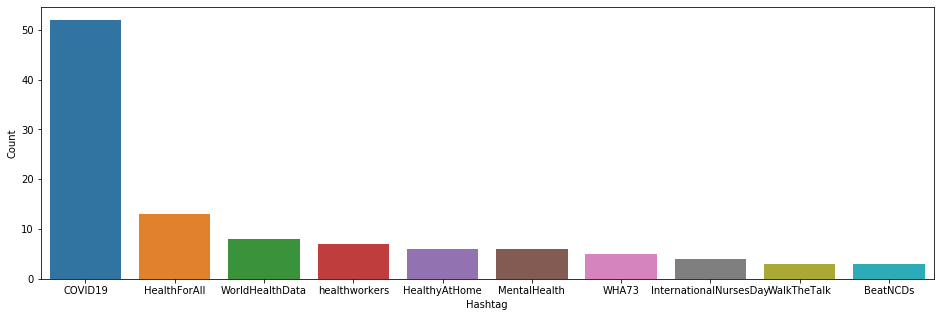

In [135]:
a = nltk.FreqDist(hashtag)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [208]:
def draw_wordcloud(tweets, color = 'black'):
        
        words = ' '.join(tweets)
        cleaned_word = " ".join([word for word in words.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and not word.startswith('#')
                                    and word != 'RT'
                                ])
        wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color=color,
                          max_words=100,
                          width=3000,
                          height=1000
                         ).generate(cleaned_word)
        plt.figure(figsize=(13, 13))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.show()

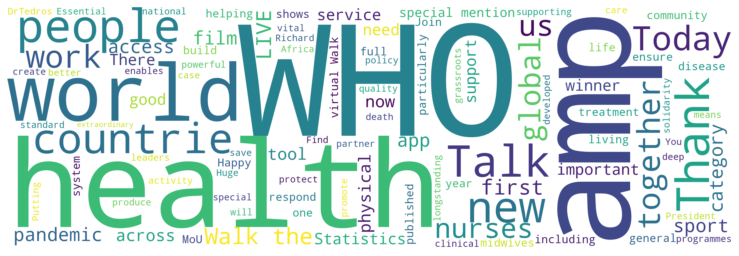

In [209]:
draw_wordcloud(positive_word, 'white')

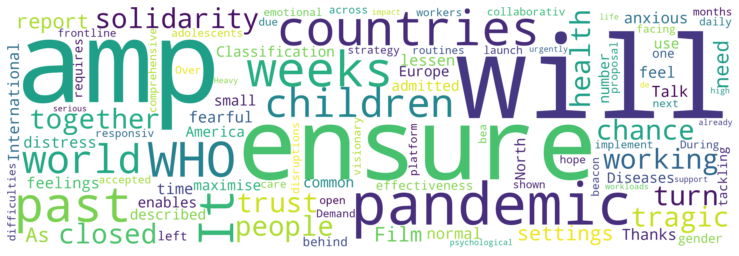

In [210]:
draw_wordcloud(negtive_word,'white')